# Introduction

Now that you can select raw data, you're ready to learn how to group your data and count things within those groups. This can help you answer questions like:

How many of each kind of fruit has our store sold?
How many species of animal has the vet office treated?
To do this, you'll learn about three new techniques: `GROUP BY`, `HAVING` and `COUNT()`. Once again, we'll use this made-up table of information on pets.

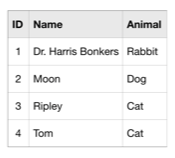

# COUNT()

COUNT(), as you may have guessed from the name, returns a count of things. If you pass it the name of a column, it will return the number of entries in that column.

For instance, if we SELECT the COUNT() of the ID column in the pets table, it will return 4, because there are 4 ID's in the table.

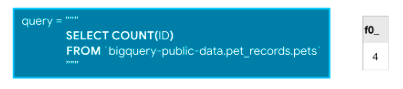

COUNT() is an example of an aggregate function, which takes many values and returns one. (Other examples of aggregate functions include SUM(), AVG(), MIN(), and MAX().) As you'll notice in the picture above, aggregate functions introduce strange column names (like f0__). Later in this tutorial, you'll learn how to change the name to something more descriptive.

# GROUP BY

GROUP BY takes the name of one or more columns, and treats all rows with the same value in that column as a single group when you apply aggregate functions like COUNT().

For example, say we want to know how many of each type of animal we have in the pets table. We can use GROUP BY to group together rows that have the same value in the Animal column, while using COUNT() to find out how many ID's we have in each group.

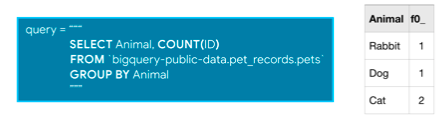

It returns a table with three rows (one for each distinct animal). We can see that the pets table contains 1 rabbit, 1 dog, and 2 cats.

# GROUP BY ... HAVING

HAVING is used in combination with GROUP BY to ignore groups that don't meet certain criteria.

So this query, for example, will only include groups that have more than one ID in them.

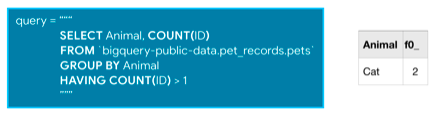

Since only one group meets the specified criterion, the query will return a table with only one row.

# Example: Which Hacker News comments generated the most discussion?

Ready to see an example on a real dataset? The Hacker News dataset contains information on stories and comments from the Hacker News social networking site.

We'll work with the 'comments' table and begin by printing the first few rows.

In [2]:
from google.cloud import bigquery

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/macbookpro/Documents/5. Kaggle/3. SQL/orbital-caldron-272723-ed30f065fd90.json"

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "comments" table
client.list_rows(table, max_results=5).to_dataframe()

,id,by,author,time,time_ts,text,parent,deleted,dead,ranking
0,2701393,5l,5l,1309184881,2011-06-27 14:28:01+00:00,And the glazier who fixed all the broken windo...,2701243,None,None,0
1,5811403,99,99,1370234048,2013-06-03 04:34:08+00:00,Does canada have the equivalent of H1B/Green c...,5804452,None,None,0
2,21623,AF,AF,1178992400,2007-05-12 17:53:20+00:00,"Speaking of Rails, there are other options in ...",21611,None,None,0
3,10159727,EA,EA,1441206574,2015-09-02 15:09:34+00:00,Humans and large livestock (and maybe even pet...,10159396,None,None,0
4,2988424,Iv,Iv,1315853580,2011-09-12 18:53:00+00:00,I must say I reacted in the same way when I re...,2988179,None,None,0


Let's use the table to see which comments generated the most replies. Since:

- the parent column indicates the comment that was replied to, and
- the id column has the unique ID used to identify each comment,

we can GROUP BY the parent column and COUNT() the id column in order to figure out the number of comments that were made as responses to a specific comment.

Furthermore, since we're only interested in popular comments, we'll look at comments with more than ten replies. So, we'll only return groups HAVING more than ten ID's.

In [6]:
query_popular = """
                SELECT parent, COUNT(id)
                FROM `bigquery-public-data.hacker_news.comments`
                GROUP BY parent
                HAVING COUNT(id) > 10
                """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_popular, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
popular_comments = query_job.to_dataframe()

# Print the first five rows of the DataFrame
popular_comments.head()

,parent,f0_
0,7204982,41
1,2559177,61
2,9070488,97
3,9459364,106
4,3402359,54


# Aliasing and other improvements


A couple hints to make your queries even better:

- The column resulting from COUNT(id) was called f0__. That's not a very descriptive name. You can change the name by adding AS NumPosts after you specify the aggregation. This is called aliasing, and it will be covered in more detail in an upcoming lesson.

- If you are ever unsure what to put inside the COUNT() function, you can do COUNT(1) to count the rows in each group. Most people find it especially readable, because we know it's not focusing on other columns. It also scans less data than if supplied column names (making it faster and using less of your data access quota).

Using these tricks, we can rewrite our query:

In [8]:
# Improved version of earlier query, now with aliasing & improved readability
query_improved = """
                 SELECT parent, COUNT(id) AS NumPosts
                 FROM `bigquery-public-data.hacker_news.comments`
                 GROUP BY parent
                 HAVING COUNT(id) > 10
                 """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_improved, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
improved_df = query_job.to_dataframe()

# Print the first five rows of the DataFrame
improved_df.head()

,parent,NumPosts
0,7021664,40
1,7213378,61
2,4325231,62
3,8979886,38
4,8399209,40


# Exercises

### 1) Prolific commenters

Hacker News would like to send awards to everyone who has written more than 10,000 posts. Write a query that returns all authors with more than 10,000 posts as well as their post counts. Call the column with post counts `NumPosts`.

In [10]:
# Query to select prolific commenters and post counts
prolific_commenters_query = """
                            SELECT author, COUNT(id) AS NumPosts
                            FROM `bigquery-public-data.hacker_news.comments`
                            GROUP BY author
                            HAVING COUNT(id) > 10000
                            """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(prolific_commenters_query, job_config=safe_config)

# API request - run the query, and return a pandas DataFrame
prolific_commenters = query_job.to_dataframe()

# View top few rows of results
print(prolific_commenters.head())

    author  NumPosts
0      eru     10448
1  rbanffy     10557
2    DanBC     12902
3    sp332     10882
4   davidw     10764


### 2) Deleted comments

How many comments have been deleted? (If a comment was deleted, the `deleted` column in the comments table will have the value `True`.)

In [13]:
num_deleted_posts_query = """
                            SELECT COUNT(id) AS Deleted_Posts
                            FROM `bigquery-public-data.hacker_news.comments`
                            WHERE deleted = True
                            """
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(num_deleted_posts_query, job_config=safe_config)

# API request - run the query, and return a pandas DataFrame
num_deleted_posts = query_job.to_dataframe()

# View top few rows of results
print(num_deleted_posts.head())

   Deleted_Posts
0         227736
